Why semi-supervised learning?

https://stats.stackexchange.com/questions/321841/what-are-variational-autoencoders-and-to-what-learning-tasks-are-they-used

Ideal parameters:
$$ \min_{\boldsymbol{\lambda}}\mathcal{D}[p(\mathbf{z}\vert \mathbf{x})\vert\vert q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda})] $$

It should also minimize the reconstruction loss (and optional regularization terms, mainly L1 or L2)

VAE loss function:
$$ELBO(\boldsymbol{\lambda})= E_{q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})}[\log p(\mathbf{x}\vert\boldsymbol{z})]-\mathcal{D}[(q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})]$$

$$ q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda}) = \mathcal{N}(\mathbf{z}\vert\boldsymbol{\mu}(\mathbf{x}), \boldsymbol{\sigma}^2(\mathbf{x})I) $$

conditional distribution:
$$ p_{\boldsymbol{\phi}}(\mathbf{x}\vert\mathbf{z}) = \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}(\mathbf{z}; \boldsymbol{\phi}), \boldsymbol{\sigma}(\mathbf{z}; \boldsymbol{\phi})^2I)$$


$$ ELBO(\boldsymbol{\theta},\boldsymbol{\phi})= \sum_i E_{q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})}[\log p_{\boldsymbol{\phi}}(\mathbf{x}_i\vert\boldsymbol{z})]-\mathcal{D}[(q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})] $$

In [1]:
# Import packages
from data_preparation.GeoParser import GeoParser
from dimension_reduction.ordination import ordination2d
from sklearn.decomposition import PCA
from IPython.display import Image
import pandas as pd
import numpy as np


Import models

In [2]:
from models.semi_supervised.deep_generative_models.models.auxiliary_dgm import AuxiliaryDeepGenerativeModel
from models.semi_supervised.deep_generative_models.models.ladder_dgm import LadderDeepGenerativeModel
from models.semi_supervised.deep_generative_models.models.dgm import DeepGenerativeModel
from utils.utils import dict_of_int_highest_elements, plot_evaluation



/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


O-sylvester


In [3]:
# files_destinations
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"

plots_folder_path = "/".join([home_path, destination_folder, results_folder, "plots/"])


In [4]:
#dataset_name = "gse33000_and_GSE24335_GSE44768_GSE44771_GSE44770"
dataset_name = "mnist"
activation = "relu"
#nrep = 3
betas=(0.9, 0.999)
vae_flavour = "o-sylvester"
early_stopping = 200
labels_per_class = 1000
n_epochs = 1000
warmup = 100
gt_input = 10000

# if ladder is yes builds a ladder vae. Do not combine with auxiliary (yet; might be possible and relatively 
# not too hard to implement, but might be overkill. Might be interesting too)
translate = "n" 


In [5]:
# Types of deep generative model

# Convolution neural network (convolutional VAE and convolutional classifier)
use_conv = False #Not applicable if not sequence (images, videos, sentences, DNA...)

# Ladder VAE (L-VAE)
ladder = False

# Auxiliary Variational Auto-Encoder (A-VAE)
auxiliary = True


In [6]:
# Load pre-computed vae (unsupervised learning)
load_vae = False



Definition of the hyper-parameters

In [7]:
lr = 1e-3
l1 = 0.
l2 = 0.
batch_size = 128
mc = 1 # seems to be a problem when mc > 1 for display only, results seem good
iw = 1 # seems to be a problem when iw > 1 for display only, results seem good

# Neurons layers
a_dim = 50
h_dims_classifier = [256]
h_dims = [128, 64]
z_dims = [50]

# number of flows
n_combinations = 20 #could be just 1 with number_of_flows?
number_of_flows = 4
num_elements = 2



In [8]:
bad_geo_ids = [""] # Now useless, didn't work well, but stil complains without it. to be removed.

In [9]:
# Files destinations
load_from_disk = True
load_merge = False
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"
plots_folder_path = "/".join([home_path, destination_folder, 
                              results_folder, "plots/"])

In [10]:
if auxiliary:
    dgm = AuxiliaryDeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows,a_dim=a_dim,
                                       num_elements=num_elements, use_conv=False, hebb_layers=True,
                                       gt_input=gt_input)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers", 
                    is_unlabelled=True)

elif ladder:
    dgm = LadderDeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows, auxiliary=False,
                                    hebb_layers=True, gt_input=gt_input)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers", 
                    is_unlabelled=True)
else:
    dgm = DeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows, a_dim=0, auxiliary=False,
                              num_elements=num_elements, hebb_layers=False, gt_input=gt_input)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers", 
                    is_unlabelled=True)

a_dim (making sure it stays ok for ssl_vae) 0
self.a_dim 50


/home/simon/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
dgm.load_example_dataset(dataset="mnist", batch_size=batch_size, 
                         labels_per_class=labels_per_class, 
                         extra_class=True, unlabelled_train_ds=True, normalize=True, mu=0.1307, var=0.3081)

is_example = True
# GET ordination from this!
train = np.vstack([x[0].data.numpy() for x in dgm.x_train])
#unlabelled_train = np.vstack([x[0].data.numpy() for x in dgm.unlabelled_x_train])

targets = np.vstack([x[1].data.numpy() for x in dgm.x_train])
labels = [x.tolist().index(1) for x in targets]


Limited number of labels: 1000
self.train_loader 79
self.train_loader 128
self.train_loader <torch.utils.data.sampler.SubsetRandomSampler object at 0x7fc0ca8d5940>


In [12]:
meta_df = pd.DataFrame(train.transpose(), columns=labels)
#unlabeled_meta_df = pd.DataFrame(unlabelled_train.transpose())


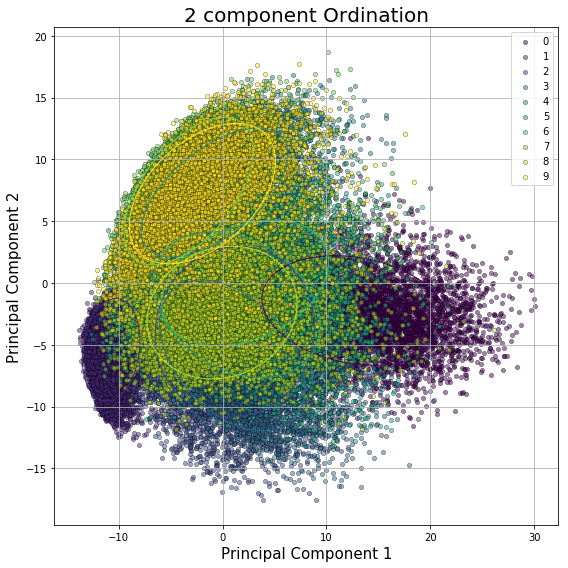

In [13]:
ordination2d(meta_df, epoch="pre", dataset_name=dataset_name, ord_type="pca",
             images_folder_path=plots_folder_path)

/home/simon/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/simon/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


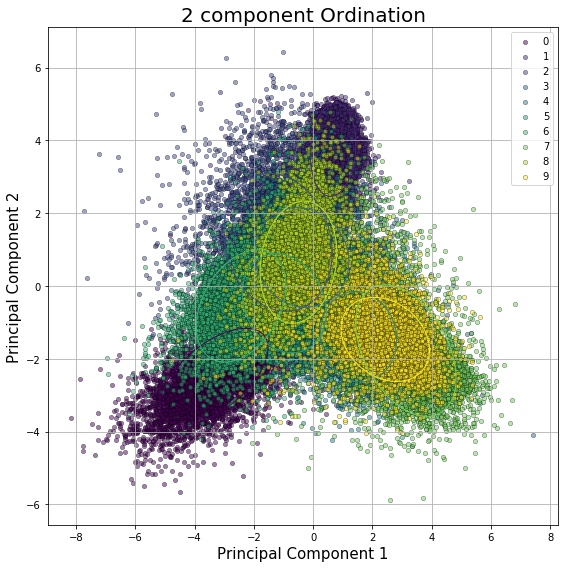

In [14]:
ordination2d(meta_df, epoch="pre", dataset_name=dataset_name, ord_type="lda",
             images_folder_path=plots_folder_path)

In [15]:
subset = pd.DataFrame(train[0:1000].transpose(), columns=labels[0:1000])

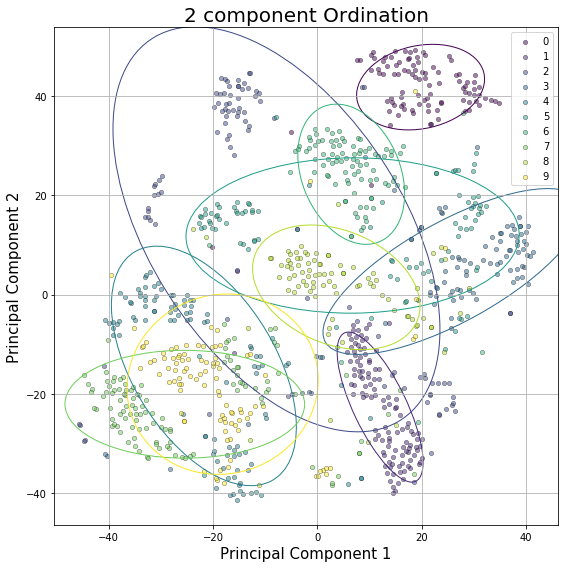

In [16]:
# tSNE
ordination2d(subset, epoch="pre", dataset_name=dataset_name, ord_type="tsne", 
             images_folder_path=plots_folder_path)

In [17]:
print("train data shape", meta_df.shape)
#print("unlabelled meta_df shape", unlabeled_meta_df.shape)

train data shape (784, 60000)


In [18]:
#if meta_df is not None:
#    dgm.import_dataframe(meta_df, batch_size, labelled=True)
    #dgm.import_dataframe(unlabelled_meta_df, batch_size, labelled=False)

In [19]:
dgm.define_configurations(early_stopping=early_stopping, warmup=warmup, flavour=vae_flavour)
dgm.set_data(labels_per_class=labels_per_class, is_example=True, extra_class=True)

In [ ]:
if auxiliary:
    if use_conv:
        dgm.set_conv_adgm_layers()
    else:
        dgm.set_adgm_layers(h_dims=h_dims_classifier, hebb_layers=True)
elif ladder:
    dgm.set_ldgm_layers(hebb_layers=True, n_channels=1)
else:
    if use_conv:
        dgm.set_conv_dgm_layers(hebb_layers=True)
    else:
        print("MAIN DGM NS")
        dgm.set_dgm_layers(hebb_layers=True)

# import the M1 in the M1+M2 model (Kingma et al, 2014). Not sure if it still works... 
if load_vae:
    print("Importing the model: ", dgm.model_file_name)
    if use_conv:
        dgm.import_cvae()
    else:
        dgm.load_model()
    #dgm.set_dgm_layers_pretrained()
dgm.cuda()
# dgm.vae.generate_random(False, batch_size, z1_size, [1, 28, 28])
dgm.run(n_epochs, auxiliary, mc, iw, lambda1=l1, lambda2=l2, verbose=2, 
        show_progress=10, show_pca_train=10, show_lda_train=10, show_pca_generated=10, clip_grad=0, 
        is_input_pruning=True, start_pruning=3, show_lda_generated=10)


self.input_size 784
self.input_size 784
Log file created:  logs/AuxiliaryDeepGenerativeModel_parameters.log
Log file created:  logs/AuxiliaryDeepGenerativeModel_involvment.log
Log file created:  logs/AuxiliaryDeepGenerativeModel.log
Labeled shape 79
Unlabeled shape 469
epoch 0


/home/simon/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[Train]		 J_a: 228.61, L: 114.81, U: 113.17, accuracy: 0.7412, kld: 8.5
[Validation]	 J_a: 160.54, L: 80.87, U: 80.04, accuracy: 0.8461 , kld: 8.9
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements2/n_flows4/z_dim50/a_dim50/lr0.001/ladderFalse/o-sylvester
epoch 1
input_size: 784
valid_bool: 784
Input layer mean hebb tensor(16641.4160, device='cuda:0')
Input layer min hebb tensor(-291.7065, device='cuda:0')
Input layer max hebb tensor(114598.8203, device='cuda:0')
input pruning...
min_hebb_value: 10000
previous_valid_len 784
self.n_channels 1
SAVING MASK at /home/simon//annleukemia/results
Current input size: 368.0 / 784
[Train]		 J_a: 149.50, L: 74.96, U: 74.31, accuracy: 0.8925, kld: 9.1
[Validation]	 J_a: 140.93, L: 70.36, U: 70.98, accuracy: 0.7984 , kld: 10.3
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements2/n_flows4/z_dim50/a_dim50/lr0.001/ladderFalse/o-sylvester
epoch 2
input_size: 784
valid_bool: 784
Input layer mean hebb tensor(43664.5508, devi

References
Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114
Semi-Supervised Learning with Deep Generative Models https://arxiv.org/abs/1406.5298
Ladder Variational Autoencoders https://arxiv.org/abs/1602.02282
Auxiliary Deep Generative Models    https://arxiv.org/abs/1602.05473
Sylvester Normalizing Flows for Variational Inference  https://arxiv.org/abs/1803.05649
Improving Variational Auto-Encoders using Householder Flow https://arxiv.org/abs/1611.09630
Variational Inference with Normalizing Flows https://arxiv.org/abs/1505.05770
Convex combination linear IAF and the Householder Flow, J.M. Tomczak & M. Welling https://jmtomczak.github.io/deebmed.html

Github Ressources:
    https://github.com/wohlert/semi-supervised-pytorch
    https://github.com/jmtomczak/vae_vpflows
    https://github.com/jmtomczak/vae_householder_flow